<a href="https://colab.research.google.com/github/sampad-singha/Alzheimer_Disease_Detection/blob/main/Sequential_Alzheimer's_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.17.1


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/small_dataset/augmented_train_sample",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/small_dataset/augmented_train_sample",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5528 files belonging to 4 classes.
Using 4423 files for training.
Found 5528 files belonging to 4 classes.
Using 1105 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [ ]:
# class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

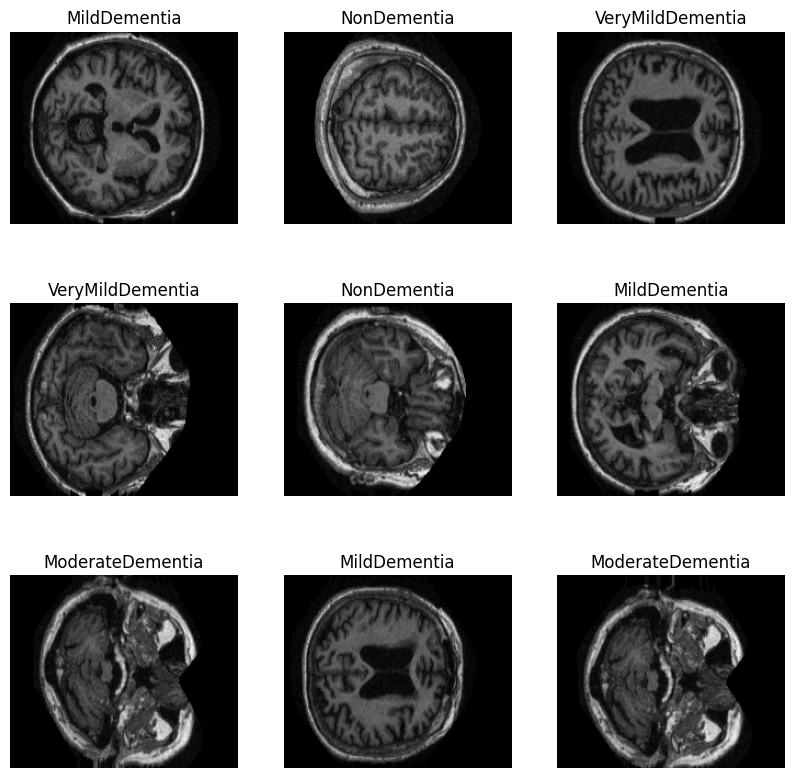

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [ ]:
# datasets = []
# for class_name in train_ds.class_names:
#     class_ds = train_ds.filter(lambda image, label: label == train_ds.class_names.index(class_name))
#     datasets.append(class_ds)

# balanced_ds = tf.data.experimental.sample_from_datasets(datasets, weights=[1/len(datasets)]*len(datasets))
# balanced_ds = balanced_ds.take(400)  # Take 400 batches from the balanced dataset

In [ ]:
# train_ds = train_ds.take(500)
# val_ds = val_ds.take(100)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = f"/content/drive/MyDrive/small_dataset/augmented_train_sample/{label}"
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, name))]))


In [ ]:
NUM_IMAGES

[1500, 1028, 1500, 1500]

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),

        # tf.keras.layers.Conv2D(16, 3, activation=None, padding='same'),
        # tf.keras.layers.LeakyReLU(negative_slope=0.01),
        # tf.keras.layers.Conv2D(16, 3, activation=None, padding='same'),
        # tf.keras.layers.LeakyReLU(negative_slope=0.01),

        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),

        dense_block(1024, 0.7), #this is new
        dense_block(512, 0.6), #this is new was 0.6
        dense_block(256, 0.5), #was 512,0.7
        dense_block(128, 0.2), #was 0.3
        dense_block(64, 0.2),  #was 0.3

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = ['accuracy', tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=5,
#     verbose=1
# )

# Model checkpoint callback (using `.keras` format)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "alzheimer_model.keras",
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 176, 208, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 208, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 104, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 44, 52, 32)          │           2,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 22, 26, 64)          │           7,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 11, 13, 128)         │          27,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 5, 6, 256)           │         103,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 1024)                │       7,869,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 512)                 │         526,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 256)                 │         132,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 128)                 │          33,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 64)                  │           8,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,713,508 (33.24 MB)

 Trainable params: 8,708,580 (33.22 MB)

 Non-trainable params: 4,928 (19.25 KB)

Let's fit our model!

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 1425s 5s/step - accuracy: 0.3931 - auc: 0.6762 - loss: 1.5078 - val_accuracy: 0.2760 - val_auc: 0.5469 - val_loss: 3.0187 - learning_rate: 0.0010
Epoch 2/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5365 - auc: 0.8131 - loss: 0.9952 - val_accuracy: 0.2760 - val_auc: 0.5460 - val_loss: 7.3295 - learning_rate: 8.9125e-04
Epoch 3/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6081 - auc: 0.8683 - loss: 0.8357 - val_accuracy: 0.2878 - val_auc: 0.6629 - val_loss: 1.9344 - learning_rate: 7.9433e-04
Epoch 4/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6468 - auc: 0.8929 - loss: 0.7587 - val_accuracy: 0.4742 - val_auc: 0.8182 - val_loss: 1.6121 - learning_rate: 7.0795e-04
Epoch 5/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7172 - auc: 0.9216 - loss: 0.6587 - val_accuracy: 0.4579 - val_auc: 0.7418 - val_loss: 2.7535 - learning_rate: 6.3096e-04
Epoch 6/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/st

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

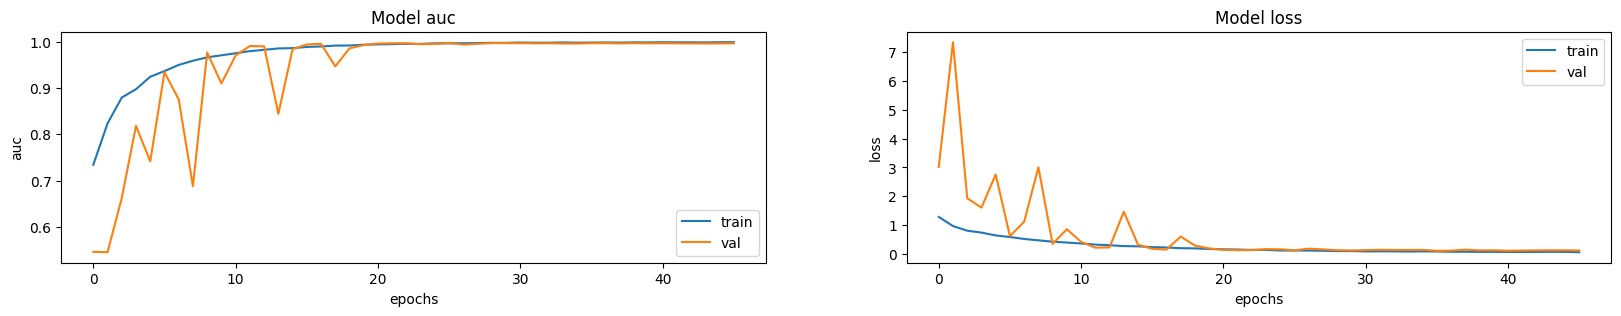

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

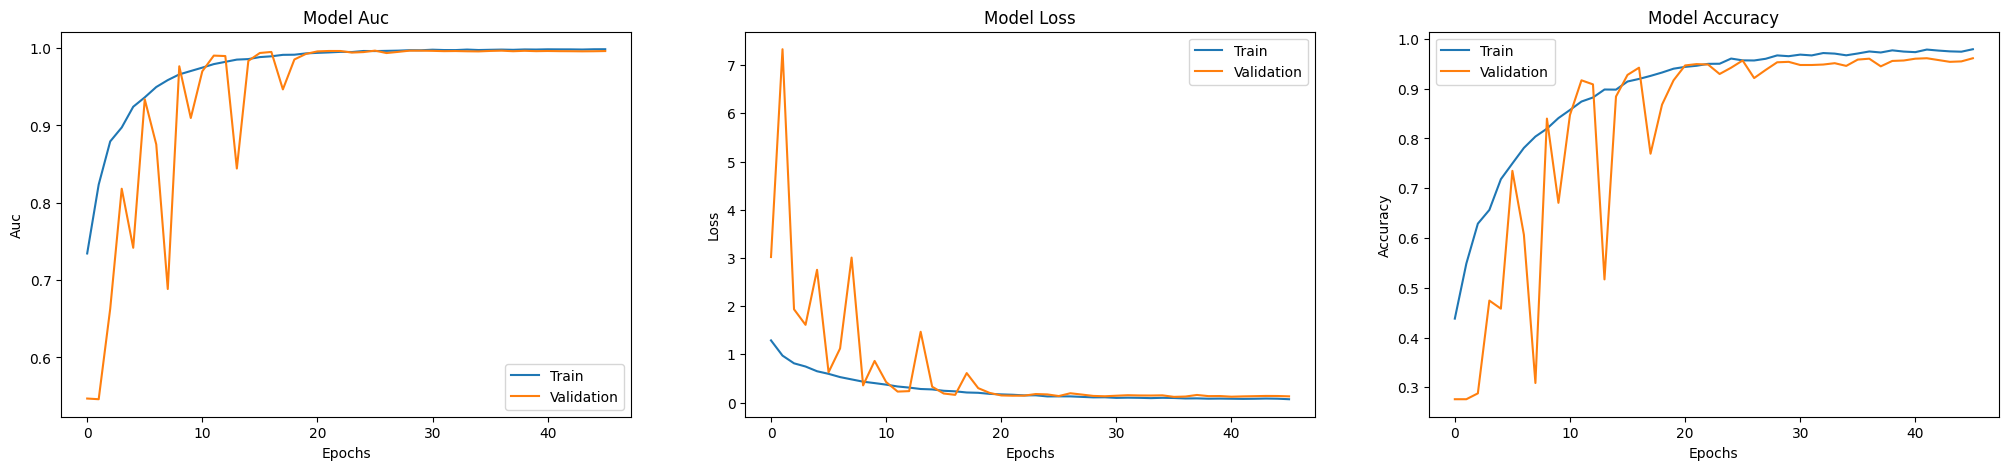

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))  # Adjusted to have 3 subplots
ax = ax.ravel()

# Plot for AUC
for i, met in enumerate(['auc', 'loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met.capitalize()))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend(['Train', 'Validation'])


# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Sm_dataset/test_sample",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3457 files belonging to 4 classes.


In [ ]:
_ = model.evaluate(test_ds)

217/217 ━━━━━━━━━━━━━━━━━━━━ 892s 4s/step - accuracy: 0.9160 - auc: 0.9800 - loss: 0.3434


In [ ]:
import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted class indices

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

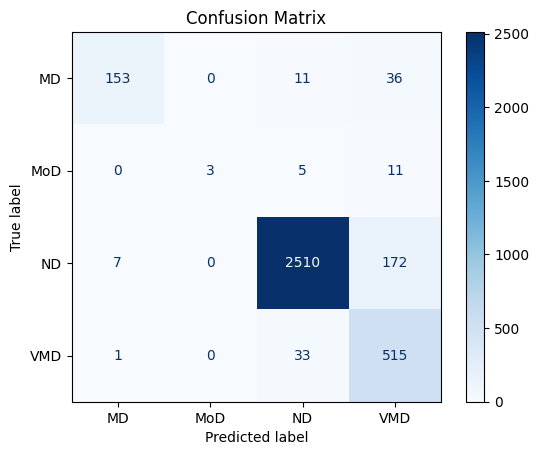

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_names  = ['MD', 'MoD', 'ND', 'VMD']
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Initialize TP, TN, FP, FN
TP = np.diag(cm)  # True Positives are the diagonal elements
FP = np.sum(cm, axis=0) - TP  # False Positives are column sums minus diagonal
FN = np.sum(cm, axis=1) - TP  # False Negatives are row sums minus diagonal
TN = np.sum(cm) - (TP + FP + FN)  # True Negatives are the total sum minus TP, FP, FN

# Initialize precision, recall, and F1-score
precision = TP / (TP + FP + 1e-10)  # Add a small value to avoid division by zero
recall = TP / (TP + FN + 1e-10)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

# Display results for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print()

# Display results for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1_score[i]:.4f}")
    print()


Class: MildDementia
  TP: 153
  TN: 3249
  FP: 8
  FN: 47

Class: ModerateDementia
  TP: 3
  TN: 3438
  FP: 0
  FN: 16

Class: NonDementia
  TP: 2510
  TN: 719
  FP: 49
  FN: 179

Class: VeryMildDementia
  TP: 515
  TN: 2689
  FP: 219
  FN: 34

Class: MildDementia
  Precision: 0.9503
  Recall: 0.7650
  F1-Score: 0.8476

Class: ModerateDementia
  Precision: 1.0000
  Recall: 0.1579
  F1-Score: 0.2727

Class: NonDementia
  Precision: 0.9809
  Recall: 0.9334
  F1-Score: 0.9566

Class: VeryMildDementia
  Precision: 0.7016
  Recall: 0.9381
  F1-Score: 0.8028



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


def load_and_preprocess_image(image_path, target_size=(176, 208)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)  # Resize to target size
    return image

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/small_dataset/test_sample/Mild Dementia/OAS1_0031_MR1_mpr-3_106.jpg'  # Path to the image you want to predict
image = load_and_preprocess_image(image_path, target_size=(176, 208))  # Match model's input size
image_batch = np.expand_dims(image, axis=0)  # Add batch dimension

predictions = model.predict(image_batch)

# If your model has multiple classes, you will get an array of probabilities
predicted_class_index = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

predicted_class_label = class_names[predicted_class_index[0]]

# Display the predicted class
print(f'Predicted class: {predicted_class_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
Predicted class: MildDementia


In [ ]:
model.save('Seq-model-final.keras')